In [2]:
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
import random
import matplotlib.pyplot as plt

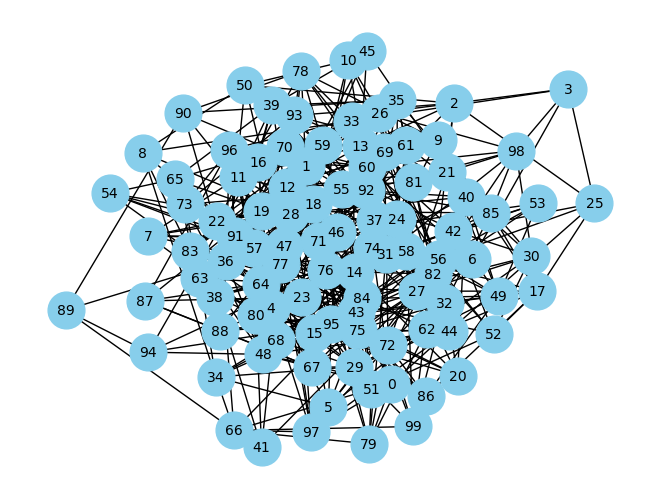

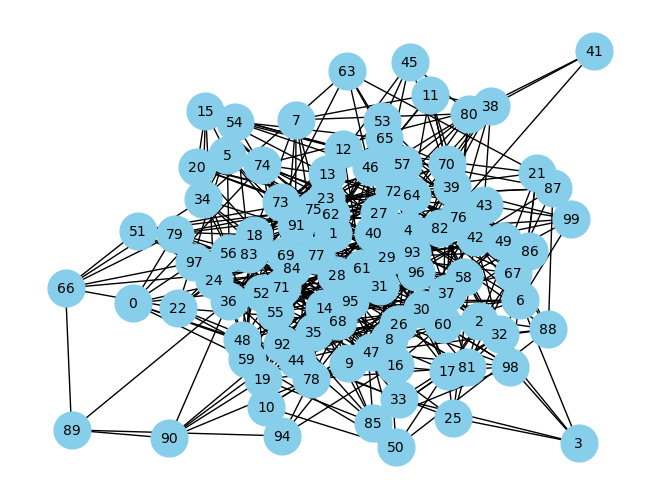

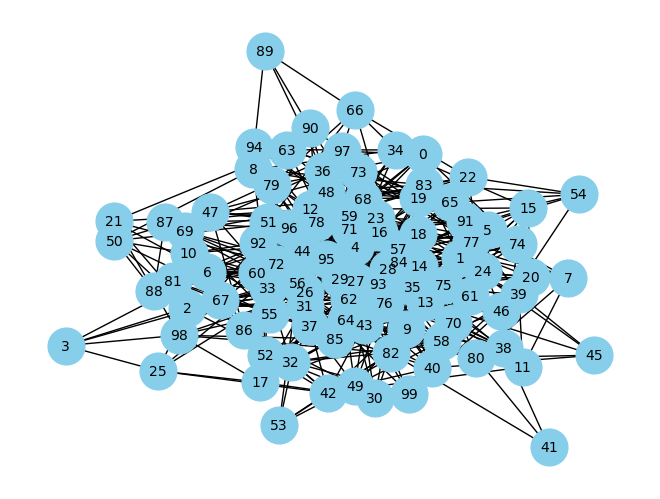

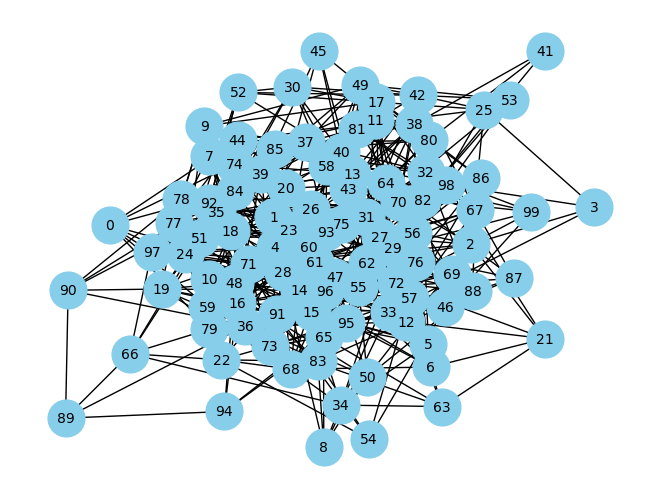

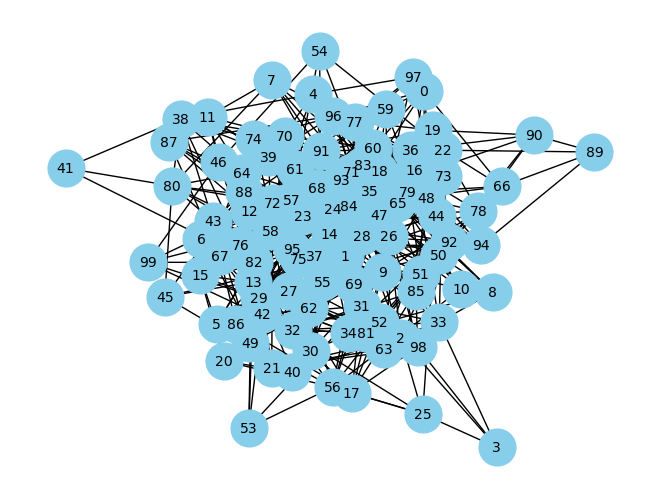

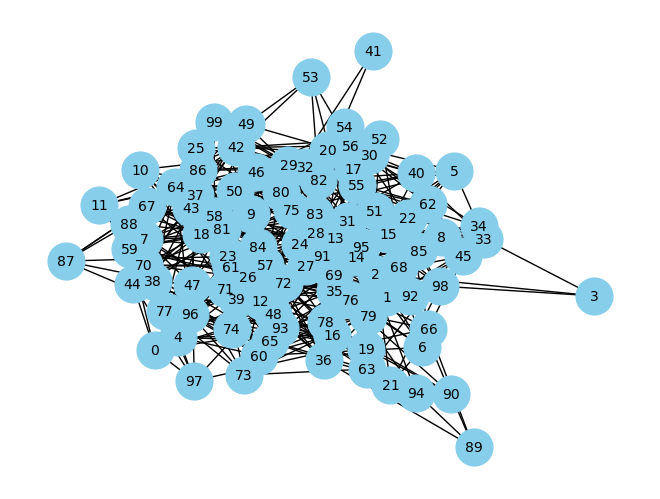

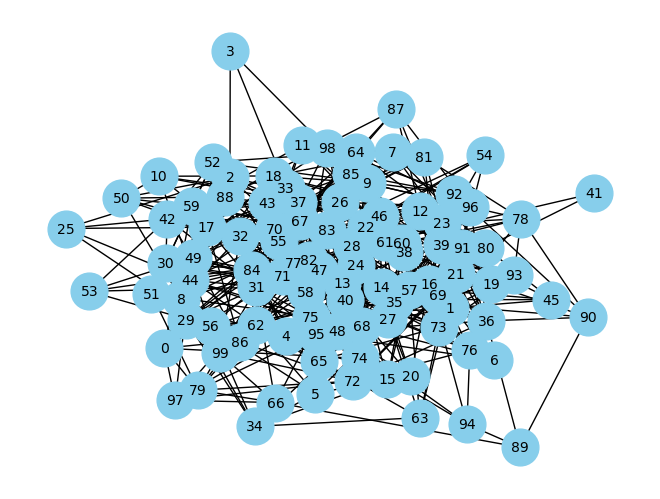

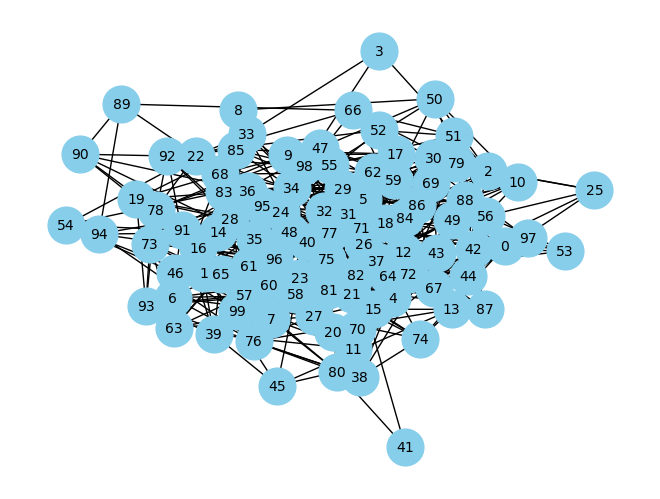

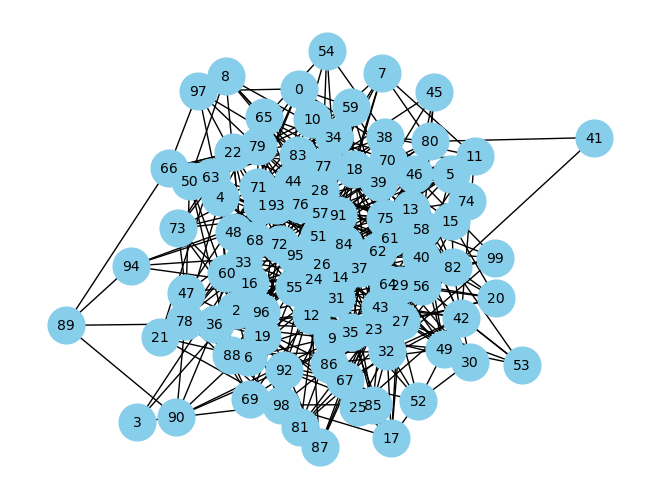

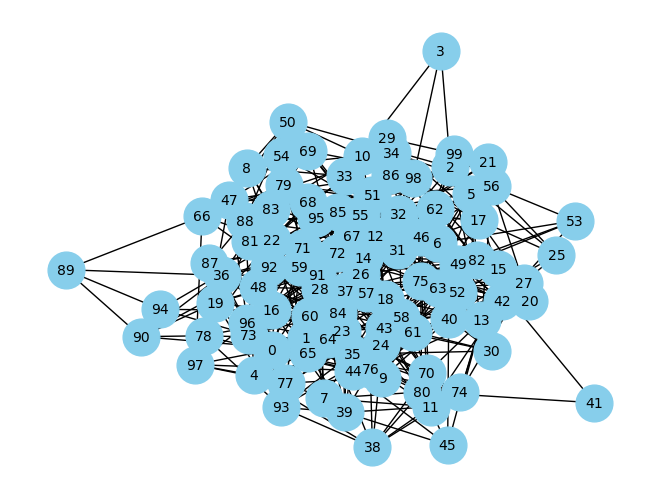

In [7]:
class SocialNetworkAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.influencer = random.choice([True, False])
        self.delta = random.random()

    def step(self):
        if self.influencer:
            self.influencer_behavior()
        else:
            self.follower_behavior()

    def influencer_behavior(self):
        neighbors = list(self.model.G.neighbors(self.pos))
        #print(len(neighbors))
        if neighbors:
            if random.random() < 0.5:
                target = self.random.choice(neighbors)
                self.model.add_connection(self.pos, target)

    def follower_behavior(self):
        neighbors = list(self.model.G.neighbors(self.pos))
        if neighbors:
            if random.random() < 0.5:
                target = self.random.choice(neighbors)
                self.model.add_connection(self.pos, target)

class SocialNetworkModel(Model):
    def __init__(self, num_agents, graph_type="random"):
        super().__init__()
        self.num_agents = num_agents
        # Random activation to ensure agents are updated in random order
        self.schedule = RandomActivation(self)

        # Create the network
        if graph_type == "random":
            self.G = nx.erdos_renyi_graph(n=num_agents, p=0.1)
        elif graph_type == "scale-free":
            self.G = nx.barabasi_albert_graph(n=num_agents, m=2)
        
        self.grid = NetworkGrid(self.G)

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            agent = SocialNetworkAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

    def add_connection(self, from_node, to_node):
        """Change add connection function"""
        if not self.G.has_edge(from_node, to_node):
            self.G.add_edge(from_node, to_node)

    def step(self):
        self.schedule.step()
        
        # Prune network (remove random fraction of links)
        self.prune_network()

    def prune_network(self):
        """Change network removal function"""
        edges = list(self.G.edges())
        num_edges_to_remove = len(edges) // self.num_agents
        edges_to_remove = random.sample(edges, num_edges_to_remove)
        self.G.remove_edges_from(edges_to_remove)

# Running the model
model = SocialNetworkModel(num_agents=100, graph_type="random")
for i in range(10):
    model.step()
    pos = nx.spring_layout(model.G)
    nx.draw(model.G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_color="black")
    plt.show()




